# Harmonization
## Erica Simon, 02/02/24
## Purpose: Use the aneris tool to harmonize emisisons datasets
- Historical (1750-2022) and projected (2020-2100) emissions datasets
    - Historical dataset is product of PRIMAP, CEDS, GCP, & GFED. More info in `hist_emis_clean`
    - Projected datasets are outputs of GCAM 6.0 NGFS, MESSAGEix-GLOBIOM, and REMIND-MAgPIE 3.2-4.6. They were last updated in November 2023 and reflect commitments made until March 2023
    
    
Credit: 
- Gidden, M. (2017). gidden/aneris: Initial release version for harmonization paper (v0.1.0). Zenodo. https://doi.org/10.5281/ZENODO.802832
- https://github.com/chrisroadmap/fair-calibrate/blob/main/input/fair-2.1.3/v1.4/all-2022/calibration/12_harmonize-emissions.py


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import aneris
import aneris.convenience
from tqdm.auto import tqdm

import datetime
import os
import warnings

<IPython.core.display.Javascript object>

## Import datasets

In [28]:
GCAM_df = pd.read_csv('~/outputs/GCAM_interp.csv')
MSG_df = pd.read_csv('~/outputs/MSG_interp.csv')
REM_df = pd.read_csv('~/outputs/REM_interp.csv')
hist_df = pd.read_csv('~/outputs/hist_emis_ALL.csv')

## Harmonize
This section of code adapted from https://github.com/chrisroadmap/fair-calibrate/blob/main/input/fair-2.1.3/v1.4/all-2022/calibration/12_harmonize-emissions.py


### set overrides

In [3]:
# Harmonization overrides - use same as RCMIP
overrides = pd.DataFrame(
    [
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|C2F6",
        },  # high historical variance (cov=16.2)
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|C6F14",
        },  # high historical variance (cov=15.4)
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|CF4",
        },  # high historical variance (cov=11.2)
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|CO",
        },  # high historical variance (cov=15.4)
        {
            "method": "reduce_ratio_2080",
            "variable": "Emissions|CO2",
        },  # always ratio method by choice
        {
            "method": "reduce_offset_2150_cov",
            "variable": "Emissions|CO2 AFOLU",
        },  # high historical variance, but using offset method to prevent diff from
        # increasing when going negative rapidly (cov=23.2)
        {
            "method": "reduce_ratio_2080",  # always ratio method by choice
            "variable": "Emissions|CO2 FFI",
        },
        #     {'method': 'default_aneris_tree', 'variable': 'Emissions|CH4'},
        # depending on the decision tree in aneris/method.py
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-125",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-134a",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-143a",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-227ea",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-23",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-32",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-4310mee",
        },  # minor f-gas with low model reporting confidence
        #     {'method': 'default_aneris_tree', 'variable': 'Emissions|N2O'},
        # depending on the decision tree in aneris/method.py
        #     {'method': 'default_aneris_tree', 'variable': 'Emissions|NH3'},
        # depending on the decision tree in aneris/method.py
        #     {'method': 'default_aneris_tree', 'variable': 'Emissions|NOx'},
        # depending on the decision tree in aneris/method.py
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|OC",
        },  # high historical variance (cov=18.5)
        {
            "method": "constant_ratio",
            "variable": "Emissions|SF6",
        },  # minor f-gas with low model reporting confidence
        #     {'method': 'default_aneris_tree', 'variable': 'Emissions|Sulfur'},
        # depending on the decision tree in aneris/method.py
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|VOC",
        },  # high historical variance (cov=12.0)
    ]
)

we need to remove the override for HFC-23 in the MESSAGE IAM because has all emissions at 0 for this specie

In [4]:
MSG_overrides = overrides[~(overrides.variable == 'Emissions|HFC-23')]

### run harmonizer

In [5]:
progress = os.getenv("PROGRESS", "False").lower() in ("true", "1", "t")

In [6]:
def harmonize(hist, future, harm_yr, overrides):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scenarios_harmonized = [
            aneris.convenience.harmonise_all(
                msdf,
                history=hist,
                year=harm_yr,
                overrides=overrides,
            )
            for _, msdf in tqdm(future.groupby(["Model", "Scenario"]), disable=1 - progress)
        ]

    scenarios_harmonized = pd.concat(scenarios_harmonized).reset_index()
    return scenarios_harmonized

In [7]:
GCAM_harm = harmonize(hist_df, GCAM_df, 2022, overrides)
MSG_harm = harmonize(hist_df, MSG_df, 2022, MSG_overrides)
REM_harm = harmonize(hist_df, REM_df, 2022, overrides)

pyam.core - WARNING: Filtered IamDataFrame is empty!
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
pyam.core - WARNING: Filtered IamDataFrame is empty!
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
pyam.core - WARNING: Filtered IamDataFrame is empty!
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
pyam.core - WARNING: Filtered IamDataFrame is empty!
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
pyam.core - WARNING: Filtered IamDataFrame i

### combine hist and future dfs into one harmonized dataset

In [8]:
yrs = np.arange(1750, 2101, 1)
new_column_order = ['model', 'scenario', 'region', 'Variable', 'unit']

for yr in yrs:
    new_column_order.append(str(yr))

In [9]:
def combine(hist_df, future_df):
    # rename to match case of hist df
    future_df = future_df.rename(columns={"variable": "Variable"})
    
    # merge hist and future
    df = pd.merge(future_df, hist_df, on='Variable', how='inner')
    
    # reorder columns to be in correct year order
    df.columns = df.columns.astype(str)
    df.drop(columns=['Model', 'Scenario', 'Region', 'Unit'], inplace=True)  # remove extra columns from hist
    df = df.iloc[:, :-1]  # remove duplicate 2022 column
    df = df[new_column_order]
    
    # update column names for uppercase consistency
    df = df.rename(columns={"model": "Model", "scenario": "Scenario", "region": "Region", "unit": "Unit"})
    
    return df

In [10]:
GCAM_full = combine(hist_df, GCAM_harm)
MSG_full = combine(hist_df, MSG_harm)
REM_full = combine(hist_df, REM_harm)

### add historical values of missing species
missing emissions data will be infilled using Silicone tool

First, gather a list of missing species for each IAM

In [11]:
GCAM_missing = np.setdiff1d(hist_df['Variable'].unique(), GCAM_full['Variable'].unique())
MSG_missing = np.setdiff1d(hist_df['Variable'].unique(), MSG_full['Variable'].unique())
REM_missing = np.setdiff1d(hist_df['Variable'].unique(), REM_full['Variable'].unique())

In [12]:
hist_df.loc[hist_df.Variable=='Emissions|C3F8']

,Model,Scenario,Region,Variable,Unit,1750,1751,1752,1753,1754,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
2,Historical,GCP+CEDS+PRIMAP+GFED,World,Emissions|C3F8,kt C3F8/yr,0.0,0.0,0.0,0.0,0.0,...,0.314138,0.323186,0.304124,0.319107,0.324656,0.324586,0.346019,0.36034,0.377938,0.380074


In [13]:
GCAM_full.loc[GCAM_full.Variable=='Emissions|C3F8']

,Model,Scenario,Region,Variable,Unit,1750,1751,1752,1753,1754,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
2,GCAM 6.0 NGFS,Below 2 C,World,Emissions|C3F8,kt C3F8/yr,0.0,0.0,0.0,0.0,0.0,...,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074
53,GCAM 6.0 NGFS,Current Policies,World,Emissions|C3F8,kt C3F8/yr,0.0,0.0,0.0,0.0,0.0,...,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074
104,GCAM 6.0 NGFS,Delayed transition,World,Emissions|C3F8,kt C3F8/yr,0.0,0.0,0.0,0.0,0.0,...,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074
155,GCAM 6.0 NGFS,Fragmented World,World,Emissions|C3F8,kt C3F8/yr,0.0,0.0,0.0,0.0,0.0,...,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074
206,GCAM 6.0 NGFS,Low demand,World,Emissions|C3F8,kt C3F8/yr,0.0,0.0,0.0,0.0,0.0,...,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074
257,GCAM 6.0 NGFS,NDCs,World,Emissions|C3F8,kt C3F8/yr,0.0,0.0,0.0,0.0,0.0,...,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074
308,GCAM 6.0 NGFS,Net Zero 2050,World,Emissions|C3F8,kt C3F8/yr,0.0,0.0,0.0,0.0,0.0,...,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074


In [14]:
GCAM_missing

array([], dtype=object)

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    for var in GCAM_missing:
        for scen in GCAM_full.Scenario.unique():
            mdl = GCAM_full.Model.values[0]
            rest = hist_df.loc[hist_df.Variable == var].values[0][2:]

            all_list = [mdl, scen, rest]
            all_list.extend(all_list.pop())

            new_row = pd.Series(index=GCAM_full.columns)
            new_row.iloc[:len(all_list)] = all_list
            GCAM_full = pd.concat([GCAM_full, new_row.to_frame().T], ignore_index=True)

In [16]:
GCAM_full.loc[GCAM_full.Variable=='Emissions|C3F8']

,Model,Scenario,Region,Variable,Unit,1750,1751,1752,1753,1754,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
2,GCAM 6.0 NGFS,Below 2 C,World,Emissions|C3F8,kt C3F8/yr,0.0,0.0,0.0,0.0,0.0,...,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074
53,GCAM 6.0 NGFS,Current Policies,World,Emissions|C3F8,kt C3F8/yr,0.0,0.0,0.0,0.0,0.0,...,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074
104,GCAM 6.0 NGFS,Delayed transition,World,Emissions|C3F8,kt C3F8/yr,0.0,0.0,0.0,0.0,0.0,...,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074
155,GCAM 6.0 NGFS,Fragmented World,World,Emissions|C3F8,kt C3F8/yr,0.0,0.0,0.0,0.0,0.0,...,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074
206,GCAM 6.0 NGFS,Low demand,World,Emissions|C3F8,kt C3F8/yr,0.0,0.0,0.0,0.0,0.0,...,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074
257,GCAM 6.0 NGFS,NDCs,World,Emissions|C3F8,kt C3F8/yr,0.0,0.0,0.0,0.0,0.0,...,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074
308,GCAM 6.0 NGFS,Net Zero 2050,World,Emissions|C3F8,kt C3F8/yr,0.0,0.0,0.0,0.0,0.0,...,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074,0.380074


### save harmonized data

In [17]:
GCAM_full.to_csv('~/outputs/GCAM_harm.csv', index=False)
MSG_full.to_csv('~/outputs/MSG_harm.csv', index=False)
REM_full.to_csv('~/outputs/REM_harm.csv', index=False)

## Visualize

In [18]:
def plot_harm(hist, future, harm_ized, var, scen):
    histt = hist.loc[hist.Variable == 'Emissions|'+var].values[0][255:]
    raw = future.loc[future.Variable == 'Emissions|'+var].loc[future.Scenario == scen].values[0][7:]
    harm = harm_ized.loc[harm_ized.variable == 'Emissions|'+var].loc[harm_ized.scenario == scen].values[0][5:]
    unit = hist.loc[hist.Variable == 'Emissions|'+var].values[0][4]
    mdl = harm_ized.model.values[0]
    
    plt.plot(np.arange(2000, 2023), histt)
    plt.plot(np.arange(2022, 2101), raw, label='unharmonized')
    plt.plot(np.arange(2022, 2101), harm, label='harmonized')
    plt.axvline(2022, linestyle='--', color='grey', alpha=0.5)
    plt.xlabel('Year')
    plt.ylabel(unit)
    plt.title('Harmonized '+var+' Emissions\n'+scen+' Scenario\n'+mdl)
    plt.legend()
    plt.show()

In [19]:
def plot_harm_ax(hist, future, harm_ized, var, scen, ax, maxes):
    histt = hist.loc[hist.Variable == 'Emissions|'+var].values[0][255:]
    raw = future.loc[future.Variable == 'Emissions|'+var].loc[future.Scenario == scen].values[0][7:]
    harm = harm_ized.loc[harm_ized.variable == 'Emissions|'+var].loc[harm_ized.scenario == scen].values[0][5:]
    unit = hist.loc[hist.Variable == 'Emissions|'+var].values[0][4]
    mdl = harm_ized.model.values[0]
    
    # find maximum value on plot
    max_val = max(raw.max(), harm.max())
    maxes.append(max_val)
    
    
    ax.plot(np.arange(2000, 2023), histt)
    ax.plot(np.arange(2022, 2101), raw)
    ax.plot(np.arange(2022, 2101), harm)
    ax.axvline(2022, linestyle='--', color='grey', alpha=0.5)
    # ax.set_ylim(0, 450)
    ax.set_title(mdl)

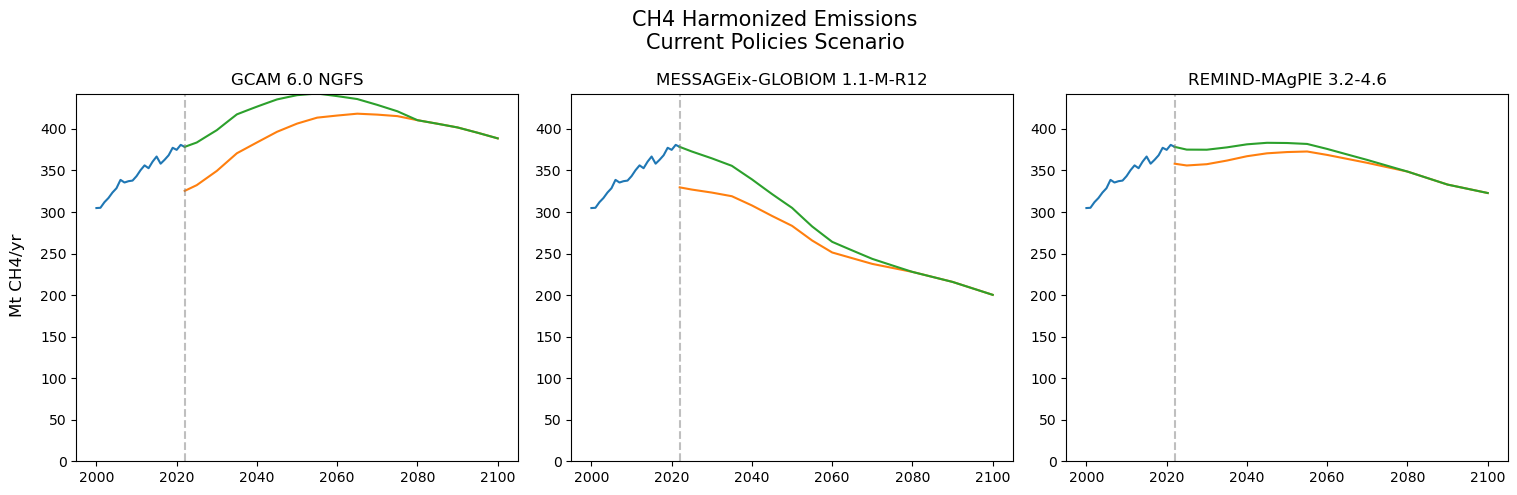

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

maxes = []

for i, (hist, future, harm) in enumerate([(hist_df, GCAM_df, GCAM_harm), (hist_df, MSG_df, MSG_harm), (hist_df, REM_df, REM_harm)]):
    plot_harm_ax(hist, future, harm, 'CH4', 'Current Policies', axs[i], maxes)
    
for i in range (len(axs)):
    axs[i].set_ylim(0, max(maxes))

plt.suptitle('CH4 Harmonized Emissions\nCurrent Policies Scenario', fontsize=15)
fig.text(-0.01, 0.45, 'Mt CH4/yr', va='center', rotation='vertical', fontsize=12)
fig.tight_layout()
plt.show()

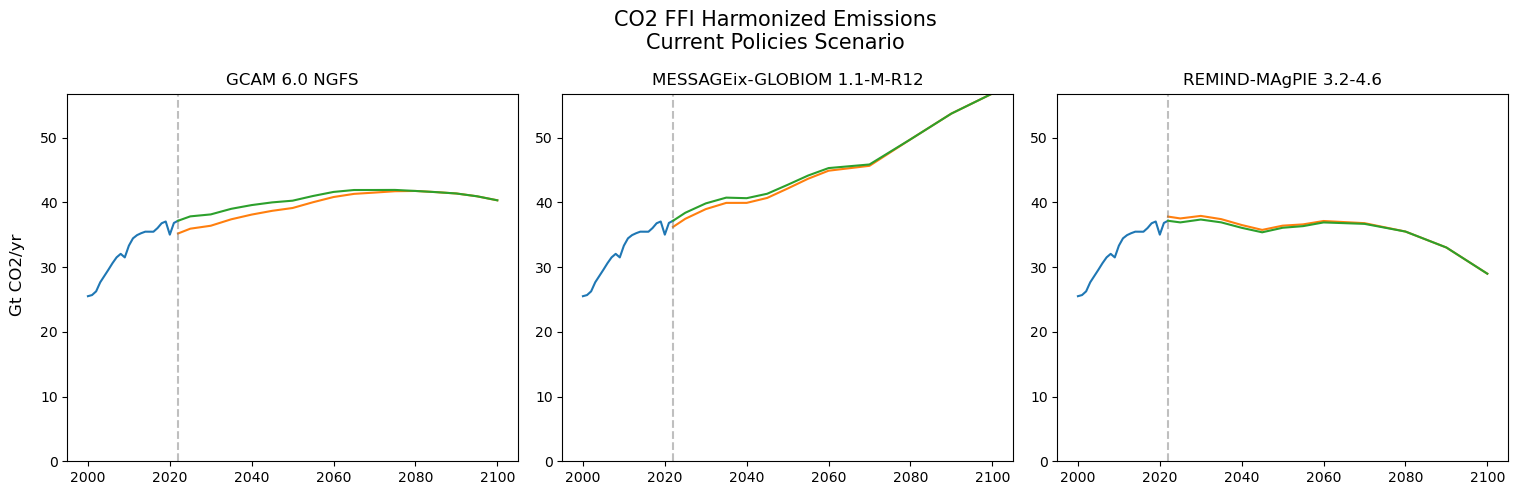

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

maxes = []

for i, (hist, future, harm) in enumerate([(hist_df, GCAM_df, GCAM_harm), (hist_df, MSG_df, MSG_harm), (hist_df, REM_df, REM_harm)]):
    plot_harm_ax(hist, future, harm, 'CO2 FFI', 'Current Policies', axs[i], maxes)

for i in range (len(axs)):
    axs[i].set_ylim(0, max(maxes))

plt.suptitle('CO2 FFI Harmonized Emissions\nCurrent Policies Scenario', fontsize=15)
fig.text(-0.01, 0.45, 'Gt CO2/yr', va='center', rotation='vertical', fontsize=12)
fig.tight_layout()
plt.show()

# check unit adjustment

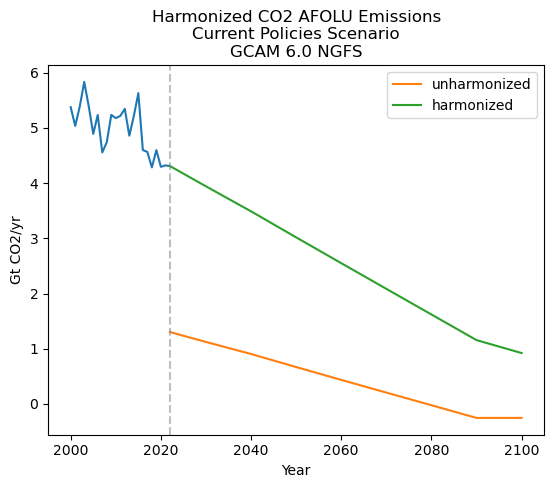

In [22]:
plot_harm(hist_df, GCAM_df, GCAM_harm, 'CO2 AFOLU', 'Current Policies')

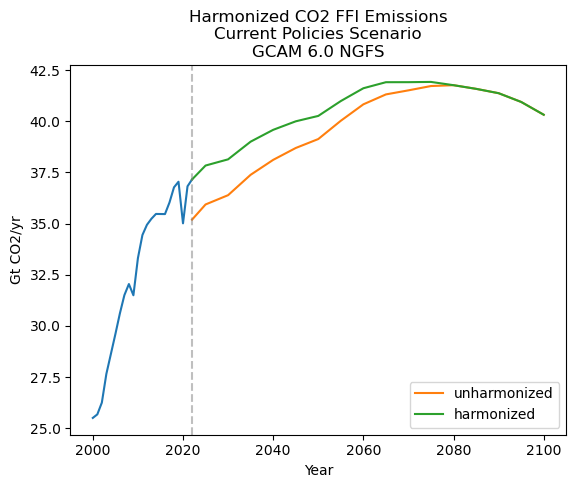

In [23]:
plot_harm(hist_df, GCAM_df, GCAM_harm, 'CO2 FFI', 'Current Policies')

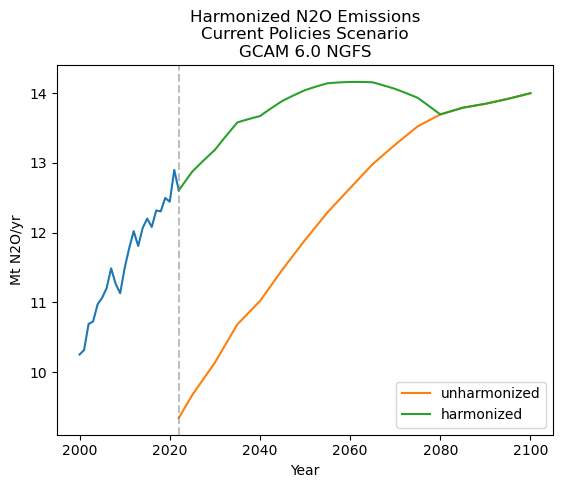

In [24]:
plot_harm(hist_df, GCAM_df, GCAM_harm, 'N2O', 'Current Policies')

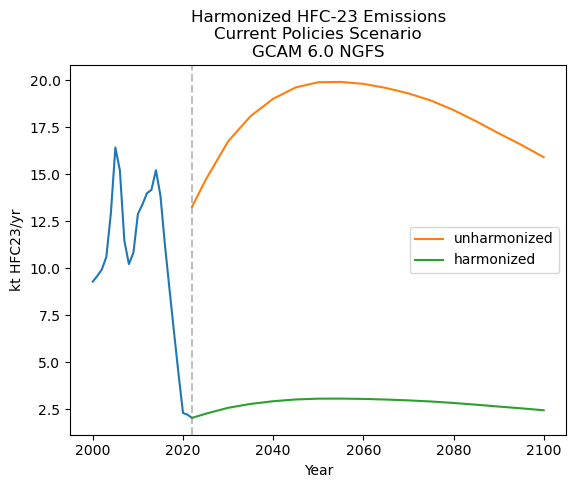

In [25]:
plot_harm(hist_df, GCAM_df, GCAM_harm, 'HFC-23', 'Current Policies')

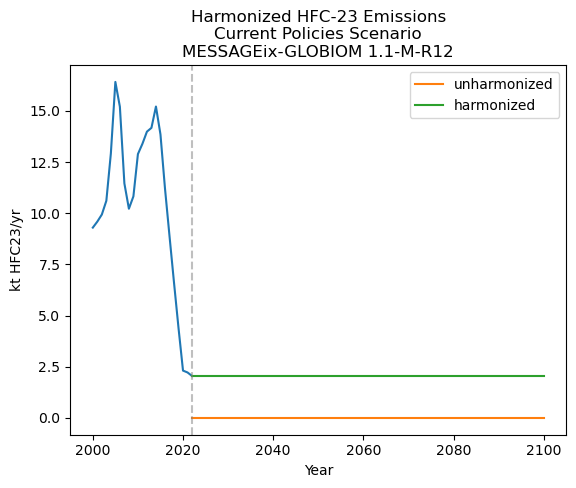

In [26]:
plot_harm(hist_df, MSG_df, MSG_harm, 'HFC-23', 'Current Policies')

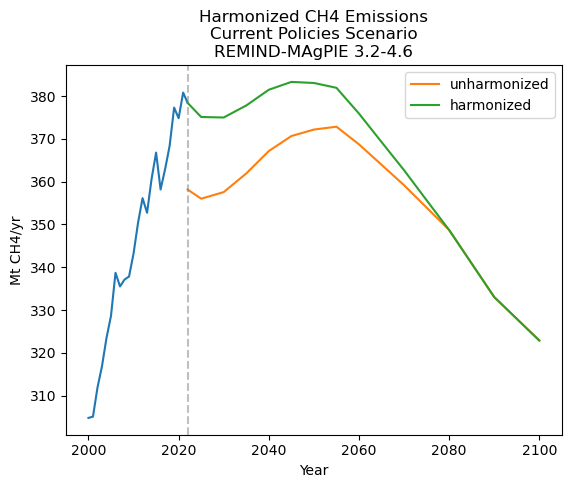

In [27]:
plot_harm(hist_df, REM_df, REM_harm, 'CH4', 'Current Policies')